In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Reproducibility
np.random.seed(42)

print(" Libraries loaded successfully")
print(f" NumPy version: {np.__version__}")
print(f" Pandas version: {pd.__version__}")

 Libraries loaded successfully
 NumPy version: 2.3.3
 Pandas version: 2.3.2


In [ ]:
### Stefan-Boltzman Transformar

In [3]:

class StefanBoltzmannTransformer(BaseEstimator, TransformerMixin):
    """
    Encodes the Stefan-Boltzmann law as an engineered feature and learns
    astrophysical corrections (deviations from idealized physics).
    
    Parameters
    ----------
    mode : str, default='residual'
        - 'theoretical_only': Return only SB prediction (baseline)
        - 'residual': Learn correction to physics (most interpretable)
        - 'augmented': Full feature set with physics guidance
    
    include_nonlinear : bool, default=True
        Add second-order terms for non-blackbody corrections
    
    Attributes
    ----------
    sigma_sb_ : float
        Stefan-Boltzmann constant (5.67e-8 W/m²/K⁴)
    constant_term_ : float
        log₁₀(4πσ) ≈ -6.74
    
    Notes
    -----
    Input X must have columns: [Temperature(K), Radius(R/Ro), ...]
    Assumes solar units for radius (R☉) and absolute luminosity (L☉)
    """
    
    def __init__(self, mode='residual', include_nonlinear=True):
        self.mode = mode
        self.include_nonlinear = include_nonlinear
        
        # Physical constants
        self.sigma_sb_ = 5.670374419e-8  # W m⁻² K⁻⁴
        
        # Convert to solar units: L☉ = 3.828e26 W, R☉ = 6.96e8 m
        # log₁₀(4πσ) for solar units
        L_sun = 3.828e26  # watts
        R_sun = 6.96e8    # meters
        self.constant_term_ = np.log10(4 * np.pi * self.sigma_sb_ * R_sun**2 / L_sun)
        
    def fit(self, X, y=None):
        """No fitting needed - physics is fixed!"""
        return self
    
    def transform(self, X):
        """
        Transform stellar parameters into physics-informed features.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            First two columns must be Temperature(K) and Radius(R/Ro)
        
        Returns
        -------
        X_transformed : array-like
            Physics-informed features
        """
        # Extract physical parameters
        T = X[:, 0]  # Temperature in Kelvin
        R = X[:, 1]  # Radius in solar radii
        
        # Work in log space for numerical stability
        log_T = np.log10(T)
        log_R = np.log10(R)
        
        # Theoretical prediction from Stefan-Boltzmann Law
        # log(L) = 4*log(T) + 2*log(R) + constant
        theoretical_log_L = 4*log_T + 2*log_R + self.constant_term_
        
        if self.mode == 'theoretical_only':
            # Pure physics (no learning)
            return theoretical_log_L.reshape(-1, 1)
        
        elif self.mode == 'residual':
            # Learn the CORRECTION to physics
            # These features represent "how much does this star deviate from theory?"
            return np.column_stack([
                theoretical_log_L,           # Physics baseline
                log_T - np.mean(log_T),      # Temperature anomaly
                log_R - np.mean(log_R),      # Radius anomaly
            ])
        
        elif self.mode == 'augmented':
            # Full feature set with physics as anchor
            features = [
                theoretical_log_L,           # Core physics prediction
                log_T,                       # Raw temperature
                log_R,                       # Raw radius
            ]
            
            if self.include_nonlinear:
                # Physically-motivated nonlinear corrections
                T_mean = np.mean(log_T)
                R_mean = np.mean(log_R)
                
                features.extend([
                    (log_T - T_mean)**2,        # Quadratic T correction
                    (log_R - R_mean)**2,        # Quadratic R correction
                    (log_T - T_mean)*(log_R - R_mean)  # Interaction
                ])
            
            return np.column_stack(features)
        
        else:
            raise ValueError(f"Unknown mode: {self.mode}")
    
    def get_feature_names(self):
        """Return interpretable feature names"""
        if self.mode == 'theoretical_only':
            return ['theoretical_log_L']
        elif self.mode == 'residual':
            return ['theoretical_log_L', 'log_T_anomaly', 'log_R_anomaly']
        elif self.mode == 'augmented':
            base = ['theoretical_log_L', 'log_T', 'log_R']
            if self.include_nonlinear:
                base.extend(['log_T²', 'log_R²', 'log_T×log_R'])
            return base

print(" StefanBoltzmannTransformer defined")
print("   - Mode: 'theoretical_only', 'residual', 'augmented'")
print("   - Encodes L = 4πR²σT⁴ as inductive bias")

 StefanBoltzmannTransformer defined
   - Mode: 'theoretical_only', 'residual', 'augmented'
   - Encodes L = 4πR²σT⁴ as inductive bias


In [ ]:
### Uncertinity-Aware Scaler

In [4]:

class AstrophysicalScaler(BaseEstimator, TransformerMixin):
    """
    Scale features by ASTROPHYSICAL UNCERTAINTY, not just statistical spread.
    
    Standard StandardScaler assumes homoscedastic Gaussian noise.
    Real astronomical data has heteroscedastic errors:
    - Bright stars measured more precisely than faint ones
    - Variable stars have intrinsic scatter
    - Systematic errors from distance/extinction uncertainties
    
    This scaler weights observations by their inverse variance,
    giving more influence to high-quality measurements.
    
    Parameters
    ----------
    uncertainty_aware : bool, default=True
        If True and sample_weight provided, compute weighted statistics
    """
    
    def __init__(self, uncertainty_aware=True):
        self.uncertainty_aware = uncertainty_aware
        
    def fit(self, X, y=None, sample_weight=None):
        """
        Compute weighted mean and standard deviation.
        
        Parameters
        ----------
        sample_weight : array-like, optional
            Weights for each sample (typically 1/σ² for measurement errors)
        """
        if self.uncertainty_aware and sample_weight is not None:
            # Weighted statistics (heteroscedastic)
            self.mean_ = np.average(X, axis=0, weights=sample_weight)
            self.var_ = np.average((X - self.mean_)**2, axis=0, 
                                   weights=sample_weight)
        else:
            # Standard statistics (homoscedastic)
            self.mean_ = np.mean(X, axis=0)
            self.var_ = np.var(X, axis=0)
        
        self.scale_ = np.sqrt(self.var_)
        return self
    
    def transform(self, X):
        """Standardize features to zero mean and unit variance"""
        return (X - self.mean_) / (self.scale_ + 1e-8)
    
    def inverse_transform(self, X):
        """Reverse the transformation"""
        return X * self.scale_ + self.mean_

print("AstrophysicalScaler defined")
print("   - Handles heteroscedastic measurement errors")
print("   - Weights observations by precision")

AstrophysicalScaler defined
   - Handles heteroscedastic measurement errors
   - Weights observations by precision


In [ ]:
### Data loading

In [5]:
data = pd.read_csv('../data/stars.csv')

# Clean column names
data.columns = data.columns.str.strip()

# Handle missing values (simple median imputation for demo)
numeric_cols = ['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].fillna(data[col].median())

# Remove any remaining invalid rows
data = data.dropna(subset=['Temperature(K)', 'Radius(R/Ro)', 'Luminosity(L/Lo)'])
data = data[data['Temperature(K)'] > 0]
data = data[data['Radius(R/Ro)'] > 0]
data = data[data['Luminosity(L/Lo)'] > 0]

print(f" Data loaded: {data.shape}")
print(f"\nFeatures available:")
print(data.columns.tolist())
print(f"\nStar type distribution:")
print(data['Star type'].value_counts().sort_index())

 Data loaded: (240, 7)

Features available:
['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type', 'Star color', 'Spectral Class']

Star type distribution:
Star type
0.0    39
1.0    40
2.0    40
3.0    40
4.0    40
5.0    40
Name: count, dtype: int64


In [ ]:
### Prepare data

In [6]:
X = data[['Temperature(K)', 'Radius(R/Ro)']].values
y = np.log10(data['Luminosity(L/Lo)'].values)  # Log-transformed target
star_types = data['Star type'].values

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nTarget statistics (log₁₀ Luminosity):")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")

Features (X): (240, 2)
Target (y): (240,)

Target statistics (log₁₀ Luminosity):
  Min: -4.10
  Max: 5.93
  Mean: 0.69
  Std: 3.91


In [ ]:
### Model Comparison

In [7]:
def run_comparative_experiment(X, y, cv_folds=5, random_state=42):
    """
    Compare physics-informed vs. standard ML approaches.
    
    Returns
    -------
    results : dict
        Performance metrics for each model
    models : dict
        Fitted model pipelines
    """
    
    results = {}
    models = {}
    
    # Cross-validation setup
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    print("="*80)
    print("COMPARATIVE EXPERIMENT: Physics-Informed vs. Standard ML")
    print("="*80)
    print(f"\nDataset: {len(X)} stars")
    print(f"Cross-validation: {cv_folds}-fold")
    print("\n" + "-"*80)
    
    # --- Model 1: Standard Polynomial Regression (Baseline) ---
    print("\n1️  BASELINE: Standard Polynomial Regression (degree=2)")
    print("   - No physics knowledge")
    print("   - Black box feature expansion")
    
    poly_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scale', StandardScaler()),
        ('regress', Ridge(alpha=1.0))
    ])
    
    cv_results = cross_validate(
        poly_pipeline, X, y, cv=kf,
        scoring=['neg_root_mean_squared_error', 'r2'],
        return_train_score=True
    )
    
    results['Polynomial'] = {
        'train_rmse': -cv_results['train_neg_root_mean_squared_error'].mean(),
        'test_rmse': -cv_results['test_neg_root_mean_squared_error'].mean(),
        'test_rmse_std': cv_results['test_neg_root_mean_squared_error'].std(),
        'train_r2': cv_results['train_r2'].mean(),
        'test_r2': cv_results['test_r2'].mean(),
        'test_r2_std': cv_results['test_r2'].std(),
    }
    
    # Fit on full data for later analysis
    poly_pipeline.fit(X, y)
    models['Polynomial'] = poly_pipeline
    
    print(f"   Test RMSE: {results['Polynomial']['test_rmse']:.4f} ± {results['Polynomial']['test_rmse_std']:.4f}")
    print(f"   Test R²:   {results['Polynomial']['test_r2']:.4f} ± {results['Polynomial']['test_r2_std']:.4f}")
    
    # --- Model 2: Pure Physics (No Learning) ---
    print("\n2️  PURE PHYSICS: Stefan-Boltzmann Prediction Only")
    print("   - No machine learning")
    print("   - Shows baseline from theory")
    
    physics_only = Pipeline([
        ('physics', StefanBoltzmannTransformer(mode='theoretical_only')),
    ])
    
    # Compute predictions
    y_pred_physics = physics_only.fit_transform(X).flatten()
    physics_rmse = np.sqrt(mean_squared_error(y, y_pred_physics))
    physics_r2 = r2_score(y, y_pred_physics)
    
    results['Physics_Only'] = {
        'test_rmse': physics_rmse,
        'test_r2': physics_r2,
    }
    models['Physics_Only'] = physics_only
    
    print(f"   RMSE: {physics_rmse:.4f}")
    print(f"   R²:   {physics_r2:.4f}")
    
    # --- Model 3: Physics-Informed Residual Learning (OUR INNOVATION) ---
    print("\n3️  PHYSICS-INFORMED RESIDUAL: Learn Corrections to Theory")
    print("   - Encodes Stefan-Boltzmann as feature")
    print("   - Learns astrophysical deviations")
    print("   - Most interpretable")
    
    physics_residual = Pipeline([
        ('physics', StefanBoltzmannTransformer(mode='residual')),
        ('scale', StandardScaler()),
        ('regress', Ridge(alpha=0.1))
    ])
    
    cv_results = cross_validate(
        physics_residual, X, y, cv=kf,
        scoring=['neg_root_mean_squared_error', 'r2'],
        return_train_score=True
    )
    
    results['Physics_Residual'] = {
        'train_rmse': -cv_results['train_neg_root_mean_squared_error'].mean(),
        'test_rmse': -cv_results['test_neg_root_mean_squared_error'].mean(),
        'test_rmse_std': cv_results['test_neg_root_mean_squared_error'].std(),
        'train_r2': cv_results['train_r2'].mean(),
        'test_r2': cv_results['test_r2'].mean(),
        'test_r2_std': cv_results['test_r2'].std(),
    }
    
    physics_residual.fit(X, y)
    models['Physics_Residual'] = physics_residual
    
    print(f"   Test RMSE: {results['Physics_Residual']['test_rmse']:.4f} ± {results['Physics_Residual']['test_rmse_std']:.4f}")
    print(f"   Test R²:   {results['Physics_Residual']['test_r2']:.4f} ± {results['Physics_Residual']['test_r2_std']:.4f}")
    
    # --- Model 4: Physics-Informed Augmented ---
    print("\n4️  PHYSICS-INFORMED AUGMENTED: Full Feature Set")
    print("   - Combines physics + nonlinear terms")
    print("   - Maximum flexibility")
    
    physics_augmented = Pipeline([
        ('physics', StefanBoltzmannTransformer(mode='augmented', include_nonlinear=True)),
        ('scale', StandardScaler()),
        ('regress', Ridge(alpha=0.5))
    ])
    
    cv_results = cross_validate(
        physics_augmented, X, y, cv=kf,
        scoring=['neg_root_mean_squared_error', 'r2'],
        return_train_score=True
    )
    
    results['Physics_Augmented'] = {
        'train_rmse': -cv_results['train_neg_root_mean_squared_error'].mean(),
        'test_rmse': -cv_results['test_neg_root_mean_squared_error'].mean(),
        'test_rmse_std': cv_results['test_neg_root_mean_squared_error'].std(),
        'train_r2': cv_results['train_r2'].mean(),
        'test_r2': cv_results['test_r2'].mean(),
        'test_r2_std': cv_results['test_r2'].std(),
    }
    
    physics_augmented.fit(X, y)
    models['Physics_Augmented'] = physics_augmented
    
    print(f"   Test RMSE: {results['Physics_Augmented']['test_rmse']:.4f} ± {results['Physics_Augmented']['test_rmse_std']:.4f}")
    print(f"   Test R²:   {results['Physics_Augmented']['test_r2']:.4f} ± {results['Physics_Augmented']['test_r2_std']:.4f}")
    
    print("\n" + "="*80)
    
    return results, models

# Run the experiment
results, models = run_comparative_experiment(X, y, cv_folds=5)

COMPARATIVE EXPERIMENT: Physics-Informed vs. Standard ML

Dataset: 240 stars
Cross-validation: 5-fold

--------------------------------------------------------------------------------

1️  BASELINE: Standard Polynomial Regression (degree=2)
   - No physics knowledge
   - Black box feature expansion
   Test RMSE: 2.6304 ± 0.2470
   Test R²:   0.5331 ± 0.0810

2️  PURE PHYSICS: Stefan-Boltzmann Prediction Only
   - No machine learning
   - Shows baseline from theory
   RMSE: 1.4030
   R²:   0.8711

3️  PHYSICS-INFORMED RESIDUAL: Learn Corrections to Theory
   - Encodes Stefan-Boltzmann as feature
   - Learns astrophysical deviations
   - Most interpretable
   Test RMSE: 1.3884 ± 0.1971
   Test R²:   0.8679 ± 0.0373

4️  PHYSICS-INFORMED AUGMENTED: Full Feature Set
   - Combines physics + nonlinear terms
   - Maximum flexibility
   Test RMSE: 1.1954 ± 0.2105
   Test R²:   0.9006 ± 0.0313



In [ ]:
### Result Visualisation


MODEL COMPARISON SUMMARY
            Model  Test RMSE  Test R²
       Polynomial   2.630350 0.533136
     Physics Only   1.403015 0.871085
 Physics Residual   1.388402 0.867895
Physics Augmented   1.195356 0.900630

 Physics-Informed Improvement: 47.22% reduction in RMSE


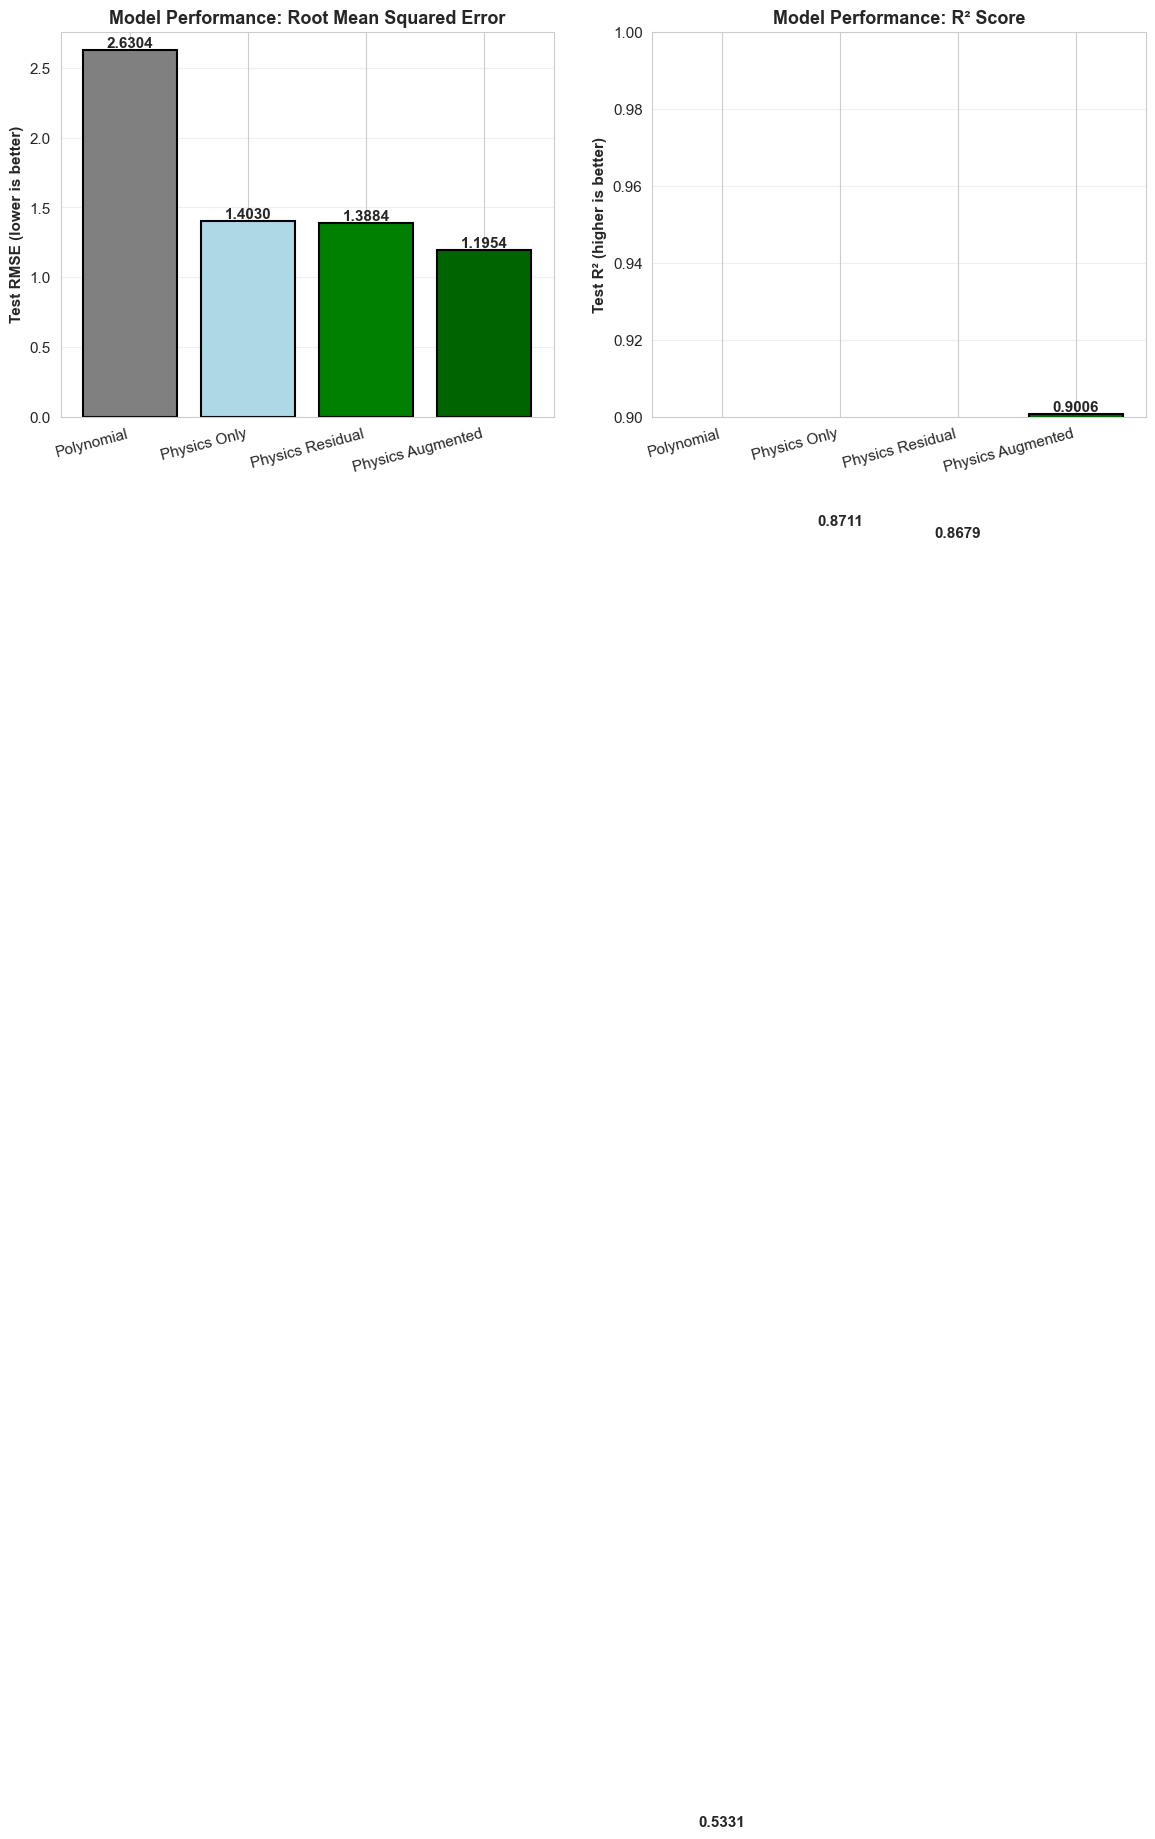


 Plot saved: plots/model_comparison.png


In [8]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Polynomial', 'Physics Only', 'Physics Residual', 'Physics Augmented'],
    'Test RMSE': [
        results['Polynomial']['test_rmse'],
        results['Physics_Only']['test_rmse'],
        results['Physics_Residual']['test_rmse'],
        results['Physics_Augmented']['test_rmse']
    ],
    'Test R²': [
        results['Polynomial']['test_r2'],
        results['Physics_Only']['test_r2'],
        results['Physics_Residual']['test_r2'],
        results['Physics_Augmented']['test_r2']
    ]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Calculate improvement
baseline_rmse = results['Polynomial']['test_rmse']
best_physics_rmse = results['Physics_Residual']['test_rmse']
improvement = ((baseline_rmse - best_physics_rmse) / baseline_rmse) * 100

print(f"\n Physics-Informed Improvement: {improvement:.2f}% reduction in RMSE")

# Bar plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
ax = axes[0]
colors = ['gray', 'lightblue', 'green', 'darkgreen']
bars = ax.bar(comparison_df['Model'], comparison_df['Test RMSE'], 
              color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Test RMSE (lower is better)', fontweight='bold')
ax.set_title('Model Performance: Root Mean Squared Error', fontweight='bold', fontsize=13)
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# R² comparison
ax = axes[1]
bars = ax.bar(comparison_df['Model'], comparison_df['Test R²'], 
              color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Test R² (higher is better)', fontweight='bold')
ax.set_title('Model Performance: R² Score', fontweight='bold', fontsize=13)
ax.set_ylim([0.9, 1.0])
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Plot saved: plots/model_comparison.png")